In [1]:
# import pyarrow.feather as feather
import numpy as np
import pandas as pd
import os
from datetime import datetime
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, make_scorer, accuracy_score, f1_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
from sklearn.ensemble import GradientBoostingRegressor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
from collections import Counter

import shap

## read the feather files

In [2]:
import os
directory_path = os.getcwd()
print("My current directory is : " + directory_path)
folder_name = os.path.basename(directory_path)
print("My directory name is : " + folder_name)

My current directory is : /home/spectre/Desktop/summer_project/Summer-project-ML
My directory name is : Summer-project-ML


In [3]:
directory_path = os.getcwd()
data_path = os.path.join(directory_path, 'data')  # the path to data folder


# list_of_feather = []
# for root, dirs, files in os.walk(data_path):
#     for file in files:
#         if file.endswith('.feather'):
#             list_of_feather.append(os.path.join(root, file))

# feather_dict = {}
# for feather_file in list_of_feather:
#     feather_name = feather_file.split('/')[-1].replace(".feather","") # the name of the feather file without the .feather extension
#     feather_dict[feather_name] = pd.read_feather(feather_file)

In [4]:
# feather_dict.keys()

In [5]:
# test = feather_dict['abr']

In [6]:
# raw_imputed = feather_dict['chars60_raw_imputed']
# raw_no_impute = feather_dict['chars60_raw_no_impute']
# rank_imputed = feather_dict['chars60_rank_imputed']
# rank_no_impute = feather_dict['chars60_raw_no_impute']

In [7]:
raw_df = pd.read_feather(os.path.join(data_path, 'chars60_raw_imputed.feather'))

In [8]:
raw_df.columns

Index(['gvkey', 'permno', 'sic', 'ret', 'exchcd', 'shrcd', 'adm', 'bm_ia',
       'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m',
       'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3',
       'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me',
       'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore',
       'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho',
       'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni',
       'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe',
       'rsup', 'sgr', 'sp', 'date', 'ffi49'],
      dtype='object')

## check missing values

In [9]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()


['adm',
 'bm_ia',
 'mom12m',
 'mom36m',
 'mom60m',
 'mom6m',
 'seas1a',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cashdebt',
 'chcsho',
 'chpm',
 'chtx',
 'gma',
 'grltnoa',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr']

## let's look at the data after 1972

In [10]:
raw_df['year'] = raw_df['date'].dt.year
raw_df = raw_df[raw_df['year'] >= 1972]
raw_df = raw_df.drop(['year'], axis=1)

In [11]:
raw_tf = raw_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

## no missing value!

## read the macro data files

In [12]:
macro_df = pd.read_csv(os.path.join(data_path, 'Macro.csv'))
macro_df = macro_df[macro_df['yyyymm']>=197201]

In [13]:
raw_df['yyyymm'] = raw_df['date'].dt.strftime("%Y%m").apply(int)
total_df = pd.merge(raw_df, macro_df, how='inner', on='yyyymm')
total_df.drop(columns="yyyymm", inplace=True)


In [14]:
raw_tf = total_df.isnull().any()
raw_tf.where(raw_tf == True).dropna().index.to_list()

[]

In [15]:
del(raw_tf)

In [16]:
len(total_df.gvkey.unique())

1552

In [17]:
total_df.permno.nunique()

1571

In [18]:
# make a list of unique permno
permno_list = total_df['permno'].unique().tolist()

In [19]:
len(total_df.columns)

77

In [20]:
total_df['exchcd'].nunique()

3

In [21]:
total_df['shrcd'].nunique()

2

In [22]:
total_df['nincr'].unique()

array([0.  , 2.  , 1.  , 3.  , 4.  , 0.5 , 5.  , 6.  , 7.  , 8.  , 1.5 ,
       2.5 , 3.5 , 0.75, 0.25])

In [23]:
total_df['pscore'].unique()

array([0.  , 2.  , 1.  , 3.  , 4.  , 5.  , 2.5 , 0.5 , 1.5 , 6.  , 3.5 ,
       5.5 , 4.5 , 4.25, 7.  , 8.  , 9.  ])

In [24]:
total_df['ffi49'].nunique()

48

## Information Variables:

   * stock indicator: gvkey, permno
   * time: datadate, date, year ('datadate' is the available time for data and 'date' is the date of return)
   * industry: sic, ffi49
   * exchange info: exchcd, shrcd
   * return: ret: the dividend adjusted return  (we also provide original return and return without dividend, you can keep them by modifing impute_rank_output_bchmk.py) 
   * market equity: me/rank_me


In [25]:
# need to turn some variables to dummy variables
def get_dummy_col(target_df, col_names):
    """turn the cols into multiple cols containing dummy variables, then drop the original columns

    Args:
        target_df (pandas dataframe): target dataframe
        col_names (list): list of columns that need to be turned into dummy variables
    """
    for col in col_names:        
        tmp_dummies = pd.get_dummies(target_df[col]).rename(columns=lambda x: f'{col}_' + str(x))
        target_df = pd.concat([target_df, tmp_dummies], axis=1)
        target_df.drop(col, inplace=True, axis = 1)
    return target_df 
dummy_col_list = ['ffi49', 'shrcd', 'exchcd']
total_df = get_dummy_col(total_df, dummy_col_list)

In [26]:
# set date as the index
total_df.set_index('date', inplace=True)

In [27]:
features_list = total_df.columns.to_list()
list_to_remove = ['gvkey', 'permno', 'ret', 'sic']
for element in list_to_remove:
    if element in features_list:
        features_list.remove(element)
        
features_list

['adm',
 'bm_ia',
 'herf',
 'hire',
 'me_ia',
 'baspread',
 'beta',
 'ill',
 'maxret',
 'mom12m',
 'mom1m',
 'mom36m',
 'mom60m',
 'mom6m',
 're',
 'rvar_capm',
 'rvar_ff3',
 'rvar_mean',
 'seas1a',
 'std_dolvol',
 'std_turn',
 'zerotrade',
 'me',
 'dy',
 'turn',
 'dolvol',
 'abr',
 'sue',
 'cinvest',
 'nincr',
 'pscore',
 'acc',
 'bm',
 'agr',
 'alm',
 'ato',
 'cash',
 'cashdebt',
 'cfp',
 'chcsho',
 'chpm',
 'chtx',
 'depr',
 'ep',
 'gma',
 'grltnoa',
 'lev',
 'lgr',
 'ni',
 'noa',
 'op',
 'pctacc',
 'pm',
 'rd_sale',
 'rdm',
 'rna',
 'roa',
 'roe',
 'rsup',
 'sgr',
 'sp',
 'b/m',
 'tbl',
 'ntis',
 'svar',
 'd/p',
 'e/p',
 'dfy',
 'tms',
 'ffi49_1',
 'ffi49_2',
 'ffi49_3',
 'ffi49_4',
 'ffi49_5',
 'ffi49_6',
 'ffi49_7',
 'ffi49_8',
 'ffi49_9',
 'ffi49_10',
 'ffi49_11',
 'ffi49_12',
 'ffi49_13',
 'ffi49_14',
 'ffi49_15',
 'ffi49_16',
 'ffi49_17',
 'ffi49_18',
 'ffi49_19',
 'ffi49_21',
 'ffi49_22',
 'ffi49_23',
 'ffi49_24',
 'ffi49_25',
 'ffi49_26',
 'ffi49_27',
 'ffi49_28',
 'ffi49_29

In [28]:
total_df.info(verbose=True)


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 462756 entries, 1972-01-31 to 2013-12-31
Data columns (total 126 columns):
 #    Column      Dtype  
---   ------      -----  
 0    gvkey       int64  
 1    permno      int64  
 2    sic         int64  
 3    ret         float64
 4    adm         float64
 5    bm_ia       float64
 6    herf        float64
 7    hire        float64
 8    me_ia       float64
 9    baspread    float64
 10   beta        float64
 11   ill         float64
 12   maxret      float64
 13   mom12m      float64
 14   mom1m       float64
 15   mom36m      float64
 16   mom60m      float64
 17   mom6m       float64
 18   re          float64
 19   rvar_capm   float64
 20   rvar_ff3    float64
 21   rvar_mean   float64
 22   seas1a      float64
 23   std_dolvol  float64
 24   std_turn    float64
 25   zerotrade   float64
 26   me          float64
 27   dy          float64
 28   turn        float64
 29   dolvol      float64
 30   abr         float64
 31   sue     

In [29]:
total_df = total_df.sort_index()

<AxesSubplot:xlabel='date'>

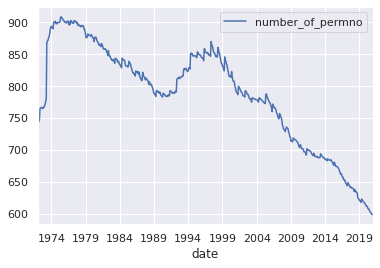

In [30]:
each_month_permno_num = pd.DataFrame(Counter(total_df.reset_index().date).items(), columns=['date', 'number_of_permno'])
each_month_permno_num.plot(x='date', y='number_of_permno')

## total:1972-2020 49 years
## training_length: 32 years; //28
## valid_length: 7 years ; //6
## testing_length: 7 years //6

In [31]:
X_total = total_df[features_list]
y_total = total_df['ret']

In [32]:
def train_val_test_preprocess(X_total, y_total, training_len, val_len, testing_len):
    """split our data into training set, validation set, and testing set

    Args:
        X_total (dataframe)
        y_total (dataframe)
        training_len (int): length of years of training set
        val_len (int)
        testing_len (int)
    return: dicts:X_train, y_train, X_val, y_val, X_test, y_test
    """
    X_train_dict = {}
    y_train_dict = {}
    X_val_dict = {}
    y_val_dict = {}
    X_test_dict = {}
    y_test_dict = {}
    first_train_end_year = y_total.index.year[0] + training_len - 1
    total_len = y_total.index.year[-1] - y_total.index.year[0] + 1
    last_train_end_year = first_train_end_year + total_len -(training_len+val_len+testing_len)
    train_end_years = np.arange(first_train_end_year, last_train_end_year+1)
    print('each end year of training set is:', train_end_years)
    for y in tqdm(train_end_years, desc='spliting data', ascii='>>'):
        train_start_year = y - training_len + 1
        train_end_year = y
        val_start_year = y + 1
        val_end_year = val_start_year+val_len-1
        test_start_year= val_end_year+val_len
        test_end_year = test_start_year+testing_len-1

        tmp_X_train = X_total[(X_total.index.year>=train_start_year) & (X_total.index.year<=train_end_year)]
        tmp_y_train = y_total[(y_total.index.year>=train_start_year) & (y_total.index.year<=train_end_year)]
        tmp_X_val = X_total[(X_total.index.year>=val_start_year) & (X_total.index.year<=val_end_year)]
        tmp_y_val = y_total[(y_total.index.year>=val_start_year) & (y_total.index.year<=val_end_year)]
        tmp_X_test = X_total[(X_total.index.year>=test_start_year) & (X_total.index.year<=test_end_year)]
        tmp_y_test = y_total[(y_total.index.year>=test_start_year) & (y_total.index.year<=test_end_year)]

        X_train_dict[y] = tmp_X_train
        y_train_dict[y] = tmp_y_train
        X_val_dict[y] = tmp_X_val
        y_val_dict[y] = tmp_y_val
        X_test_dict[y] = tmp_X_test
        y_test_dict[y] = tmp_y_test
    return train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict
        

In [33]:
train_end_years, X_train_dict, y_train_dict, X_val_dict, y_val_dict, X_test_dict, y_test_dict = train_val_test_preprocess(X_total, y_total, 32, 7, 7)


each end year of training set is: [2003 2004 2005 2006]


spliting data: 100%|>>>>>>>>>>| 4/4 [00:00<00:00,  4.39it/s]


In [34]:
# to save memory
del(X_total)
del(y_total)
del(total_df)
del(macro_df)
del(raw_df)
del(element)


In [35]:
class GBRT_Reg:
    def __init__(self, train_end_year, X_train, y_train, X_val, y_val, X_test, y_test):
        self._train_end_year = train_end_year
        self._X_train = X_train
        self._y_train = y_train
        self._X_val = X_val
        self._y_val = y_val
        self._X_test = X_test
        self._y_test = y_test
        
        self.result_cols = ['year','y_pred', 'y_real', 'params', 'pred_R2_OOS',
                         'CV_R2', 'CV_MSE']
        
        
    def get_res(self):
        """return a list of results, and a dataframe containing the r2 reduction of each feature.
        """
        res = []
        features = self._X_train.columns
        dummy_columns = [x for x in features if x.startswith('ffi49') or x.startswith('shrcd') or x.startswith('exchcd')]
        dummy_col_name_list = ['ffi49', 'shrcd', 'exchcd']
        normal_features = [x for x in features if x not in dummy_columns]
        total_feature_name = normal_features + dummy_col_name_list
        r2_oos_reduction_df = pd.DataFrame(columns=['R2OOS', 'R2OOS_Reduction', 'R2OOS_Normalized'], index=total_feature_name)
        
        reg = gbrt(self._X_train, self._y_train, self._X_val, self._y_val, gridsearch=False)
        _y_pred = reg.predict(self._X_test)
        pred_r2_score = r2_oos(self._y_test, _y_pred)
                # year, y_pred, y_real, best_parmans, prediction score (R^2 OOS),
        #      CV result(R2_OOS)(Mean cross-validated score of the best_estimator), CV result(MSE)
        res.append([self._train_end_year, _y_pred, self._y_test, reg.best_params_, pred_r2_score, reg.best_score_, reg.cv_results_['mean_test_mse']])

        for feature in total_feature_name:
            if feature in normal_features:
                new_X_test = self._X_test.copy(deep=True)
                new_X_test[feature] = 0
                new_pred = reg.predict(new_X_test)
                new_r2_score = r2_oos(y_test, new_pred)
                r2_oos_reduction_df.loc[feature, "R2OOS"] = new_r2_score
            else:
                tmp_dummy_cols = [x for x in dummy_columns if x.startswith(feature)]
                new_X_test = self._X_test.copy(deep=True)
                new_X_test[tmp_dummy_cols] = 0
                new_pred = reg.predict(new_X_test)
                new_r2_score = r2_oos(y_test, new_pred)
                r2_oos_reduction_df.loc[feature, "R2OOS"] = new_r2_score
                

        r2_oos_reduction_df['R2OOS_Reduction'] = (pred_r2_score - r2_oos_reduction_df["R2OOS"]).abs()
        r2_oos_reduction_df['R2OOS_Normalized'] = r2_oos_reduction_df['R2OOS_Reduction'] / r2_oos_reduction_df['R2OOS_Reduction'].sum()
        r2_oos_reduction_df = r2_oos_reduction_df.sort_values(by='R2OOS_Normalized')

        return res, r2_oos_reduction_df

In [36]:
dummy_col_list

['ffi49', 'shrcd', 'exchcd']

In [37]:
# not used
def general_report(y_real, y_pred):
    print("the Accuracy is:", accuracy_score(y_real, y_pred))
    print('the F1 score is:', f1_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

use R2 reduction rather than ssd to measure the feature importance

In [38]:
# R_square_oos
def r2_oos(ret, pred):
    sum_of_sq_res = np.nansum(np.power((ret-pred), 2))
    sum_of_sq_total = np.nansum(np.power(ret, 2))
    
    return 1-sum_of_sq_res/sum_of_sq_total



In [39]:
r2oos_score = make_scorer(r2_oos, greater_is_better=True)  
# pred_score = r2oos_score(reg, self.x_test, self.y_test)
# can be used in gridsearchcv by 'scoring=r2oos_score'

#reference:https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
#https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html


reference:https://stackoverflow.com/questions/48390601/explicitly-specifying-test-train-sets-in-gridsearchcv

since we prespicified the training and validation set, we need to modify the cv parameter in gridsearchcv

In [40]:
# GBRT+H
#use pipeline to + a scaler（standardize）, then use gridsearchcv/randomsearchcv
def gbrt(X_train, y_train, X_valid, y_valid, gridsearch = True):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', GradientBoostingRegressor(loss='huber', random_state=777))
    ])

    param_grid = dict(clf__learning_rate=[0.01, 0.04, 0.07, 0.1],
                    clf__n_estimators=[100, 200, 300, 500], 
                    clf__max_depth=[1, 2, 3, 4])
    # use two scorer:r2oos and mse 
    # scoring_dict = ['r2oos_score', 'neg_mean_squared_error']
    scoring_dict = {'r2_oos':r2oos_score, 'mse':'neg_mean_squared_error'}

    # The indices which have zero or positive values, will be kept in val
    len_X_train = len(X_train)
    len_X_val = len(X_valid)
    val_fold = np.repeat([-1, 0], [len_X_train, len_X_val])
    ps = PredefinedSplit(val_fold)

    X_train_n_val = pd.concat([X_train, X_valid])
    y_train_n_val = pd.concat([y_train, y_valid])
    # notice the cv=ps
    if gridsearch:
        grid = GridSearchCV(pipe, param_grid=param_grid, cv=ps, n_jobs=8, verbose=2, scoring= scoring_dict, refit='r2_oos')
    else:
        grid = RandomizedSearchCV(pipe, param_grid, cv=ps, n_jobs=8, n_iter=15, verbose=2, scoring= scoring_dict, refit ='r2_oos') #could try n_iter=60 for better result

    grid.fit(X_train_n_val, y_train_n_val)

    #get the best score with grid.best_score_
    #get the best parameters with grid.best_params_
    #get the best model with grid.best_estimator_
    return grid

In [41]:
# starts training 
if __name__ == '__main__':
    result = []
    r2_oos_df = pd.DataFrame()
    for year in tqdm(train_end_years, ascii='>>'):
        X_train = X_train_dict[year]
        y_train = y_train_dict[year]
        X_val = X_val_dict[year]
        y_val = y_val_dict[year]
        X_test = X_test_dict[year]
        y_test = y_test_dict[year]
        tmp_mod = GBRT_Reg(year, X_train, y_train, X_val, y_val, X_test, y_test)
        tmp_result, tmp_r2oos_reduction_df = tmp_mod.get_res()
        result.append(tmp_result)
        r2_oos_df = pd.concat([r2_oos_df, tmp_r2oos_reduction_df])
    res_cols = tmp_mod.result_cols
    # result_df = pd.DataFrame(result, columns=res_cols)
    result_df = pd.DataFrame()
    for i in range(len(result)):
        result_df = pd.concat([result_df, pd.DataFrame(result[i], columns=res_cols)])

  0%|>>>>>>>>>>| 0/4 [00:00<?, ?it/s]

['adm', 'bm_ia', 'herf', 'hire', 'me_ia', 'baspread', 'beta', 'ill', 'maxret', 'mom12m', 'mom1m', 'mom36m', 'mom60m', 'mom6m', 're', 'rvar_capm', 'rvar_ff3', 'rvar_mean', 'seas1a', 'std_dolvol', 'std_turn', 'zerotrade', 'me', 'dy', 'turn', 'dolvol', 'abr', 'sue', 'cinvest', 'nincr', 'pscore', 'acc', 'bm', 'agr', 'alm', 'ato', 'cash', 'cashdebt', 'cfp', 'chcsho', 'chpm', 'chtx', 'depr', 'ep', 'gma', 'grltnoa', 'lev', 'lgr', 'ni', 'noa', 'op', 'pctacc', 'pm', 'rd_sale', 'rdm', 'rna', 'roa', 'roe', 'rsup', 'sgr', 'sp', 'b/m', 'tbl', 'ntis', 'svar', 'd/p', 'e/p', 'dfy', 'tms', 'ffi49', 'shrcd', 'exchcd']
Fitting 1 folds for each of 15 candidates, totalling 15 fits


  0%|>>>>>>>>>>| 0/4 [00:57<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
if not os.path.exists('result_data'):
    os.makedirs('result_data')

In [ ]:
result_df.to_csv('result_data/gbrt_result.csv')
r2_oos_df.to_csv('result_data/gbrt_r2oos_reduction.csv')

## plot the feature importance of the model

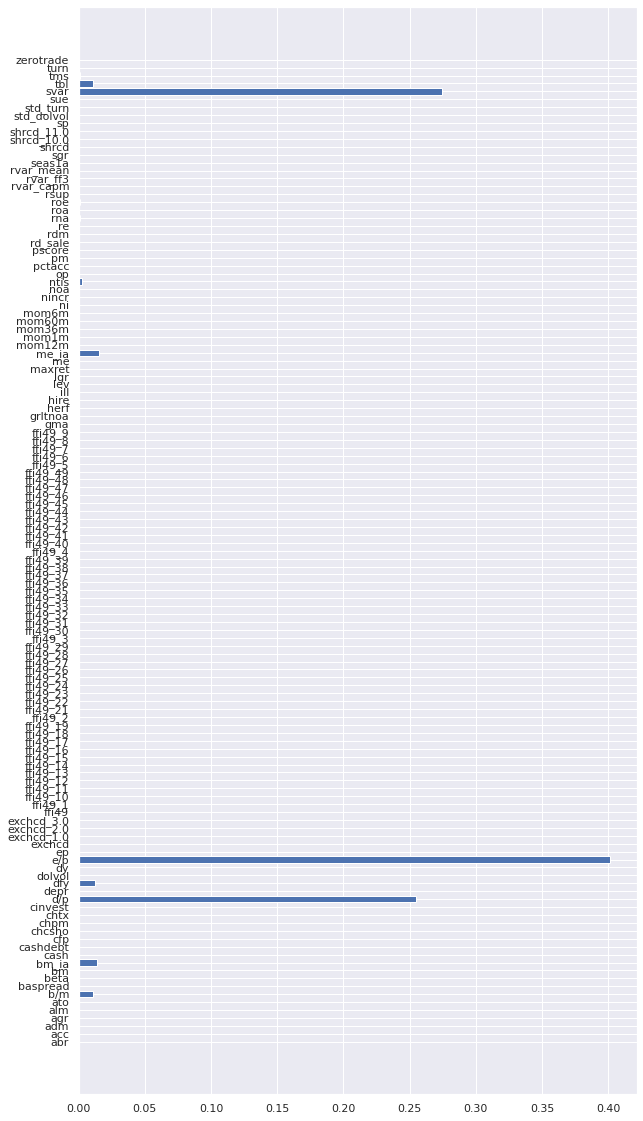

In [ ]:
r2_reduction_mean = r2_oos_df.groupby(level=0)['R2OOS_Normalized'].mean()
plt.figure(figsize=(10, 20))
plt.barh(r2_reduction_mean.index, r2_reduction_mean)
plt.show()

In [ ]:
r2_oos_df

,R2OOS,R2OOS_Reduction,R2OOS_Normalized
adm,0.090137,0.0,0.0
shrcd,0.090137,0.0,0.0
cash,0.090137,0.0,0.0
cashdebt,0.090137,0.0,0.0
cfp,0.090137,0.0,0.0
...,...,...,...
shrcd_10.0,NaN,NaN,NaN
shrcd_11.0,NaN,NaN,NaN
exchcd_1.0,NaN,NaN,NaN
exchcd_2.0,NaN,NaN,NaN


In [ ]:
result_df

,year,y_pred,y_real,params,pred_R2_OOS,CV_R2,CV_MSE
0,2003,"[0.014453369898151873, 0.014948365914038524, 0...",date 2017-01-31 0.068468 2017-01-31 0.00...,"{'clf__n_estimators': 200, 'clf__max_depth': 1...",0.090137,0.054918,"[-0.013116710850420854, -0.014938067675387781,..."
0,2004,"[0.021766514045301145, 0.014761674095633009, 0...",date 2018-01-31 0.021895 2018-01-31 -0.00...,"{'clf__n_estimators': 100, 'clf__max_depth': 1...",0.091974,0.056038,"[-0.013284531980657922, -0.013517689179284227,..."
0,2005,"[0.016535277069634566, 0.016535277069634566, 0...",date 2019-01-31 0.108143 2019-01-31 0.10...,"{'clf__n_estimators': 100, 'clf__max_depth': 1...",0.102786,0.057604,"[-0.013639554817660713, -0.015219612903963389,..."
0,2006,"[0.01842011864790541, 0.01577903869977837, 0.0...",date 2020-01-31 -0.121690 2020-01-31 0.12...,"{'clf__n_estimators': 200, 'clf__max_depth': 1...",0.112608,0.065365,"[-0.014356071928789873, -0.014068282003507923,..."


In [ ]:
tmp_best_params = result_df[result_df['pred_R2_OOS'] == max(result_df['pred_R2_OOS'])]['params']

In [ ]:
for key in tmp_best_params.keys():
    print(key, tmp_best_params[key])

0 {'clf__n_estimators': 200, 'clf__max_depth': 1, 'clf__learning_rate': 0.1}


# best pararms records
*  n_estimators = 200, max_depth = 1, learning rate = 0.1 bad performance

In [ ]:
mean_r2oos = np.mean(result_df['pred_R2_OOS'])
print(mean_r2oos)

0.0993763676475749


# notes 
* do we really need rolling
* consider using polynormial feature
* dummy_varaibles, especially ffi49 creates too many columns, and we think it would damage the performance, is there a way to avoid this?

In [ ]:

from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [ ]:
# example
def regress_test(X, y, regressor, params = None,
            target ='daily_ret', window = 120, pred_window = 30):
    # training with 6month(120days) and predict 3month(60days)
    tscv = TimeSeriesSplit() # n_splits=_num_batch

    pf = PolynomialFeatures(degree=1)

    estimator = Pipeline([
        ('scaler', StandardScaler()),
        ("polynomial_features", pf),
        ("ridge_regression", ridge)])


In [ ]:
# #PCA Not used
# #TODO:change this
# pipe = Pipeline([
#         ('scale', StandardScaler()),
#         ('reduce_dims', PCA(n_components=4)),
#         ('clf', SVC(kernel = 'linear', C = 1))]) 

# param_grid = dict(reduce_dims__n_components=[4,6,8],
#                   clf__C=np.logspace(-4, 1, 6),
#                   clf__kernel=['rbf','linear'])

# grid = GridSearchCV(pipe, param_grid=param_grid, cv=3, n_jobs=1, verbose=2, scoring= 'accuracy')
# grid.fit(X, y)
# print(grid.best_score_)
# print(grid.cv_results_)

### shap values, need more research, don't use it yet

In [ ]:
# # Tree SHAP is an algorithm to compute exact SHAP values for Decision Trees based models. 
# # SHAP (SHapley Additive exPlanation) is a game theoretic approach to explain the output of any machine learning model. 
# # The goal of SHAP is to explain the prediction for any instance xᵢ as a sum of contributions from it’s individual feature values. 
# #reference:https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137#a3a1
# def feature_importance_plot_single_model(clf, mod_type, X_test):
# # chart with features listed in order of importance
# # if our case, for clf, we might need reg.best_estimator_ or grid.best_estimator_
#     if mod_type == 'tree':
#         explainer = shap.TreeExplainer(clf)
#     if mod_type == 'linear':
#         explainer = shap.LinearExplainer(clf)
#     if mod_type == 'neural_network':
#         explainer = shap.KernelExplainer(clf)

#     shap_values = explainer.shap_values(X_test)

#     # shap.summary_plot(shap_values, X_test, plot_type="bar")
#     # shap.summary_plot(shap_values, X_test)
#     shap.plots.bar(shap_values=shap_values)

# def feature_importance_all_heatmap(shap_df, name):
#     #TODO:finish this function
#     result = result.astype("float")
#     result = result.iloc[::-1]
#     scalar = MinMaxScaler()
#     result = scalar.fit_transform(result)
#     result = pd.DataFrame(result, columns=name, index=(rsl[0].index)[::-1])
#     plt.figure(figsize=(15, 15)) # 后面改
#     sns.heatmap(result,cmap="Blues")
#     plt.show()
#     return None



## Marginal Association Between Characteristics and Expected Return

# use dm-test to compare models
# we could use this package provided by https://github.com/johntwk/Diebold-Mariano-Test